本次以英雄联盟对局胜负预测任务为基础，要求实现决策树算法相关细节，加深对算法的理解，并了解做机器学习任务的大致流程。

## 任务介绍
英雄联盟（League of Legends，LoL）是一个多人在线竞技游戏，由拳头游戏（Riot Games）公司出品。在游戏中，每位玩家控制一位有独特技能的英雄，红蓝两支队伍各有五位玩家进行对战，目标是摧毁对方的基地水晶。水晶有多座防御塔保护，通常需要先摧毁一些防御塔再摧毁水晶。玩家所控制的英雄起初非常弱，需要不断击杀小兵、野怪和对方英雄来获得金币、经验。经验可以提升英雄等级和技能等级，金币可以用来购买装备提升攻击、防御等属性。对战过程中一般没有己方单位在附近的地点是没有视野的，即无法看到对面单位，双方可以通过使用守卫来监视某个地点，洞察对面走向、制定战术。
本数据集来自[Kaggle](https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min)，包含了9879场钻一到大师段位的单双排对局，对局双方几乎是同一水平。每条数据是前10分钟的对局情况，每支队伍有19个特征，红蓝双方共38个特征。这些特征包括英雄击杀、死亡，金钱、经验、等级情况等等。一局游戏一般会持续30至40分钟，但是实际前10分钟的局面很大程度上影响了之后胜负的走向。作为最成功的电子竞技游戏之一，对局数据、选手数据的量化与研究具有重要意义，可以启发游戏将来的发展和改进。

本任务是希望同学们依据注释的要求，对代码中空缺部分进行填写，**完成决策树模型的详细实现**，根据已有的对局前10分钟特征信息，预测最后获胜方是蓝色方还是红色方，了解执行一个**机器学习任务的大致流程**，并**提交代码和实验报告**。第一次作业也是一个机器学习小实验的例子，之后的作业可能不再提供预处理等流程代码，由同学们自己设计实验完成代码编写。

数据源： https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min

## 探索数据分析

### 导入工具包
pandas是数据分析和处理常用的工具包，非常适合处理行列表格数据。numpy是数学运算工具包，支持高效的矩阵、向量运算。sklearn是机器学习常用工具包，包括了一些已经实现好的简单模型和一些常用数据处理方法、评价指标等函数。

In [1]:
import numpy as np 
import pandas as pd
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier

RANDOM_SEED = 42

In [2]:
# display all columns
pd.set_option('display.max_columns', None)

### 读入数据
假设数据文件放在`./data/`目录下，标准的csv文件可以用pandas里的`read_csv()`函数直接读入。文件共有40列，38个特征（红蓝方各19），1个标签列（blueWins），和一个对局标号（gameId）。对局标号不是标签也不是特征，可以舍去。

In [3]:
data_path = './data/high_diamond_ranked_10min.csv'
raw_df = pd.read_csv(data_path, sep=',')

###  数据概览
对于一个机器学习问题，在拿到任务和数据后，首先需要观察数据的情况，比如我们可以通过`.iloc[0]`取出数据的第一行并输出。不难看出每个特征都存成了float64浮点数，该对局蓝色方开局10分钟有小优势。同时也可以发现有些特征列是重复冗余的，比如blueGoldDiff表示蓝色队金币优势，redGoldDiff表示红色方金币优势，这两个特征是完全对称的互为相反数。blueCSPerMin是蓝色方每分钟击杀小兵数，它乘10就是10分钟所有小兵击杀数blueTotalMinionsKilled。在之后的特征处理过程中可以考虑去除这些冗余特征。
另外，pandas有非常方便的`describe()`函数，可以直接通过DataFrame进行调用，可以展示每一列数据的一些统计信息，对数据分布情况有大致了解，比如blueKills蓝色方击杀英雄数在前十分钟的平均数是6.14、方差为2.93，中位数是6，百分之五十以上的对局中该特征在4-8之间，等等。

In [4]:
data_df = raw_df.copy()

In [5]:
data_df.head(3)

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [7]:
data_df.blueWins.value_counts()

0    4949
1    4930
Name: blueWins, dtype: int64

* 数据类型全部为numerical
* 不存在缺失数据
* `blueWins`为label列
* 一共9879条记录，正样本4949，负样本4930，正负样本比例均衡

**原始特征**

|特征|描述|
|---|---|
|blueWardsPlaced|Number of warding totems placed by the blue team on the map|
|blueWardsDestroyed|Number of enemy warding totems the blue team has destroyed|
|blueFirstBlood|First kill of the game. 1 if the blue team did the first kill, 0 otherwise|
|blueKills|Number of enemies killed by the blue team|
|blueDeaths|Number of deaths (blue team)|
|blueAssists|Number of kill assists (blue team)|
|blueEliteMonsters|Number of elite monsters killed by the blue team (Dragons and Heralds)|
|blueDragons|Number of dragons killed by the blue team|
|blueHeralds|Number of heralds killed by the blue team|
|blueTowersDestroyed|Number of structures destroyed by the blue team (towers...)|
|blueTotalGold|Blue team total gold|
|blueAvgLevel|Blue team average champion level|
|blueTotalExperience|Blue team total experience|
|blueTotalMinionsKilled|Blue team total minions killed (CS)|
|blueTotalJungleMinionsKilled|Blue team total jungle monsters killed|
|blueGoldDiff|Blue team gold difference compared to the enemy team|
|blueExperienceDiff|Blue team experience difference compared to the enemy team|
|blueCSPerMin|Blue team CS (minions) per minute|
|blueGoldPerMin|Blue team gold per minute|

In [8]:
data_df = data_df.drop(columns=['gameId'])

In [9]:
data_df.loc[1, :]

blueWins                            0.0
blueWardsPlaced                    12.0
blueWardsDestroyed                  1.0
blueFirstBlood                      0.0
blueKills                           5.0
blueDeaths                          5.0
blueAssists                         5.0
blueEliteMonsters                   0.0
blueDragons                         0.0
blueHeralds                         0.0
blueTowersDestroyed                 0.0
blueTotalGold                   14712.0
blueAvgLevel                        6.6
blueTotalExperience             16265.0
blueTotalMinionsKilled            174.0
blueTotalJungleMinionsKilled       43.0
blueGoldDiff                    -2908.0
blueExperienceDiff              -1173.0
blueCSPerMin                       17.4
blueGoldPerMin                   1471.2
redWardsPlaced                     12.0
redWardsDestroyed                   1.0
redFirstBlood                       1.0
redKills                            5.0
redDeaths                           5.0


In [10]:
data_df.describe()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,0.499038,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.549954,0.361980,0.187974,0.051422,16503.455512,6.916004,17928.110133,216.699565,50.509667,14.414111,-33.620306,21.669956,1650.345551,22.367952,2.723150,0.495192,6.137666,6.183925,6.662112,0.573135,0.413098,0.160036,0.043021,16489.041401,6.925316,17961.730438,217.349226,51.313088,-14.414111,33.620306,21.734923,1648.904140
std,0.500024,18.019177,2.174998,0.500002,3.011028,2.933818,4.064520,0.625527,0.480597,0.390712,0.244369,1535.446636,0.305146,1200.523764,21.858437,9.898282,2453.349179,1920.370438,2.185844,153.544664,18.457427,2.138356,0.500002,2.933818,3.011028,4.060612,0.626482,0.492415,0.366658,0.216900,1490.888406,0.305311,1198.583912,21.911668,10.027885,2453.349179,1920.370438,2.191167,149.088841
min,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10730.000000,4.600000,10098.000000,90.000000,0.000000,-10830.000000,-9333.000000,9.000000,1073.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000,-11467.000000,-8348.000000,10.700000,1121.200000
25%,0.000000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,15415.500000,6.800000,17168.000000,202.000000,44.000000,-1585.500000,-1290.500000,20.200000,1541.550000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,15427.500000,6.800000,17209.500000,203.000000,44.000000,-1596.000000,-1212.000000,20.300000,1542.750000
50%,0.000000,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,16398.000000,7.000000,17951.000000,218.000000,50.000000,14.000000,-28.000000,21.800000,1639.800000,16.000000,2.000000,0.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,16378.000000,7.000000,17974.000000,218.000000,51.000000,-14.000000,28.000000,21.800000,1637.800000
75%,1.000000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,0.000000,0.000000,17459.000000,7.200000,18724.000000,232.000000,56.000000,1596.000000,1212.000000,23.200000,1745.900000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,0.000000,0.000000,17418.500000,7.200000,18764.500000,233.000000,57.000000,1585.500000,1290.500000,23.300000,1741.850000
max,1.000000,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,2.000000,1.000000,1.000000,4.000000,23701.000000,8.000000,22224.000000,283.000000,92.000000,11467.000000,8348.000000,28.300000,2370.100000,276.000000,24.000000,1.000000,22.000000,22.000000,28.000000,2.000000,1.000000,1.000000,2.000000,22732.000000,8.200000,22269.000000,289.000000,92.000000,10830.000000,9333.000000,28.900000,2273.200000


In [11]:
blue_features = list(filter(lambda feat: feat.startswith('blue'), data_df.columns[1:]))
red_features = list(filter(lambda feat: feat.startswith('red'), data_df.columns[1:]))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1310b6780>,
      dtype=object)

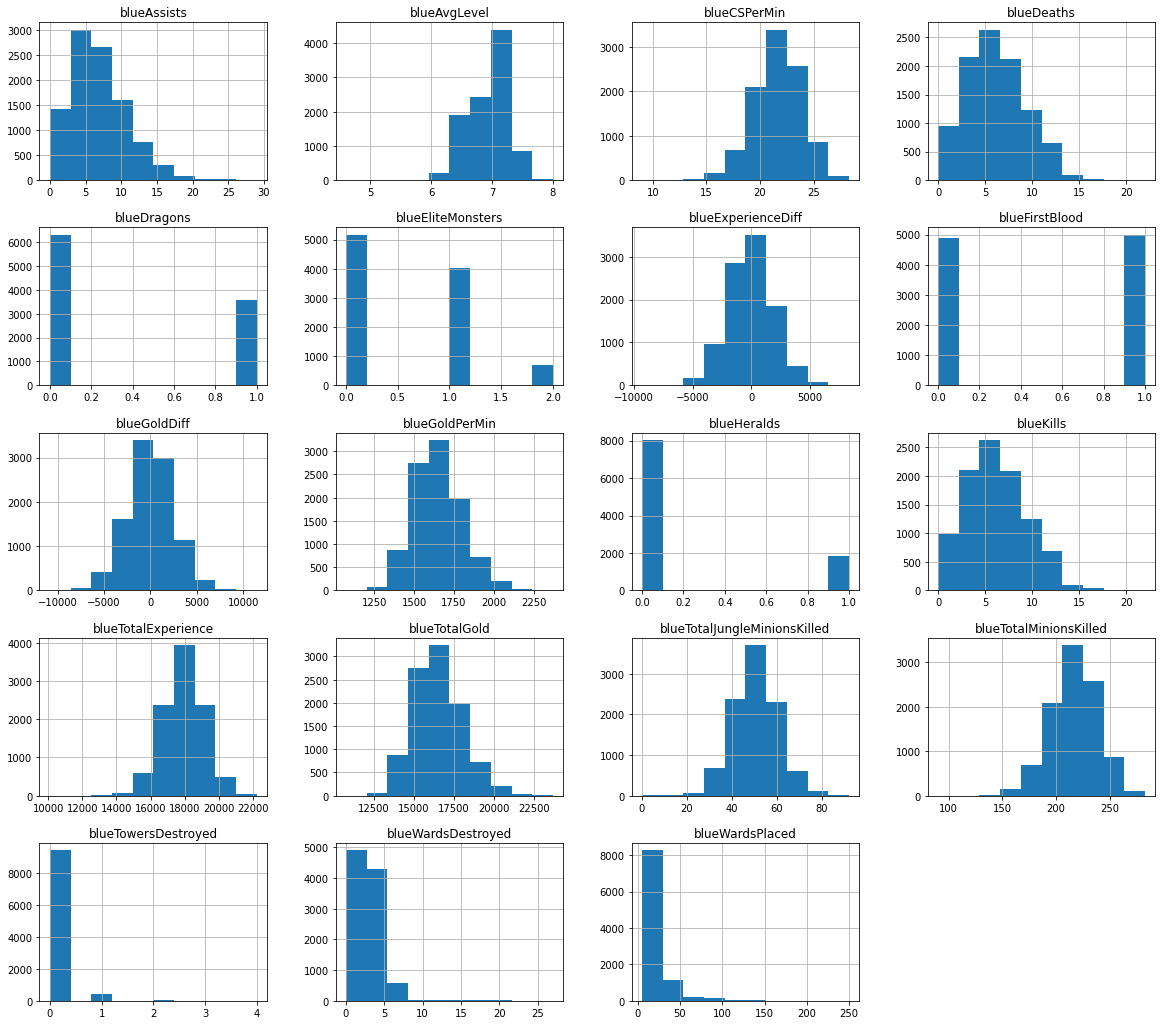

In [12]:
data_df[blue_features].hist(figsize=(20, 18))

In [13]:
data_df[blue_features].corr()

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin
blueWardsPlaced,1.000000,0.034447,0.003228,0.018138,-0.002612,0.033217,0.019892,0.017676,0.010104,0.009462,0.019725,0.034349,0.031719,-0.033925,0.010501,0.015800,0.027943,-0.033925,0.019725
blueWardsDestroyed,0.034447,1.000000,0.017717,0.033748,-0.073182,0.067793,0.041700,0.040504,0.016940,-0.009150,0.060054,0.060294,0.067462,0.111028,-0.023452,0.078585,0.077946,0.111028,0.060054
blueFirstBlood,0.003228,0.017717,1.000000,0.269425,-0.247929,0.229485,0.151603,0.134309,0.077509,0.083316,0.312058,0.177617,0.190365,0.125642,0.018190,0.378511,0.240665,0.125642,0.312058
blueKills,0.018138,0.033748,0.269425,1.000000,0.004044,0.813667,0.178540,0.170436,0.076195,0.180314,0.888751,0.434867,0.472155,-0.030880,-0.112506,0.654148,0.583730,-0.030880,0.888751
blueDeaths,-0.002612,-0.073182,-0.247929,0.004044,1.000000,-0.026372,-0.204764,-0.188852,-0.095527,-0.071441,-0.162572,-0.414755,-0.460122,-0.468560,-0.228102,-0.640000,-0.577613,-0.468560,-0.162572
blueAssists,0.033217,0.067793,0.229485,0.813667,-0.026372,1.000000,0.149043,0.170873,0.028434,0.123663,0.748352,0.292661,0.303022,-0.062035,-0.134023,0.549761,0.437002,-0.062035,0.748352
blueEliteMonsters,0.019892,0.041700,0.151603,0.178540,-0.204764,0.149043,1.000000,0.781039,0.640271,0.166644,0.239396,0.203530,0.232774,0.118762,0.198378,0.281464,0.263991,0.118762,0.239396
blueDragons,0.017676,0.040504,0.134309,0.170436,-0.188852,0.170873,0.781039,1.000000,0.020381,0.039750,0.186413,0.160683,0.179083,0.086686,0.159595,0.233875,0.211496,0.086686,0.186413
blueHeralds,0.010104,0.016940,0.077509,0.076195,-0.095527,0.028434,0.640271,0.020381,1.000000,0.217901,0.153974,0.128201,0.152386,0.083509,0.121291,0.162943,0.162496,0.083509,0.153974
blueTowersDestroyed,0.009462,-0.009150,0.083316,0.180314,-0.071441,0.123663,0.166644,0.039750,0.217901,1.000000,0.350941,0.124453,0.139398,0.092291,0.008165,0.294060,0.218320,0.092291,0.350941


## 特征工程

### 增删特征
传统的机器学习模型大部分都是基于特征的，因此特征工程是机器学习中非常重要的一步。有时构造一个好的特征比改进一个模型带来的提升更大。这里简单展示一些特征处理的例子。首先，上面提到，特征列中有些特征信息是完全冗余的，会给模型带来不必要的计算量，可以去除。其次，相比于红蓝双方击杀、助攻的绝对值，可能双方击杀英雄的差值更能体现出当前对战的局势。因此，我们可以构造红蓝双方对应特征的差值。数据文件中已有的差值是金币差GoldDiff和经验差ExperienceDiff，实际上每个对应特征都可以构造这样的差值特征。

### 差值特征

删除原有差值特征，使用原始红蓝双方特征构建差值特征。

删除原有差值特征：

In [14]:
drop_features = ['blueGoldDiff', 'redGoldDiff', 'blueExperienceDiff', 'redExperienceDiff']
data_df.drop(columns=drop_features, inplace=True)

构建所有原始特征的差值特征：

In [15]:
feat_names = list(map(lambda feat: feat[3:], filter(lambda feat: feat.startswith('red'), data_df.columns)))
diff_features = []

for feat in feat_names:
    diff_feat_name = feat + 'BRDiff'
    blue_feat_name = 'blue' + feat
    red_feat_name = 'red' + feat
    data_df[diff_feat_name] = data_df[blue_feat_name] - data_df[red_feat_name]
    diff_features.append(diff_feat_name)

In [16]:
diff_features

['WardsPlacedBRDiff',
 'WardsDestroyedBRDiff',
 'FirstBloodBRDiff',
 'KillsBRDiff',
 'DeathsBRDiff',
 'AssistsBRDiff',
 'EliteMonstersBRDiff',
 'DragonsBRDiff',
 'HeraldsBRDiff',
 'TowersDestroyedBRDiff',
 'TotalGoldBRDiff',
 'AvgLevelBRDiff',
 'TotalExperienceBRDiff',
 'TotalMinionsKilledBRDiff',
 'TotalJungleMinionsKilledBRDiff',
 'CSPerMinBRDiff',
 'GoldPerMinBRDiff']

In [17]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 52 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   blueWins                        9879 non-null   int64  
 1   blueWardsPlaced                 9879 non-null   int64  
 2   blueWardsDestroyed              9879 non-null   int64  
 3   blueFirstBlood                  9879 non-null   int64  
 4   blueKills                       9879 non-null   int64  
 5   blueDeaths                      9879 non-null   int64  
 6   blueAssists                     9879 non-null   int64  
 7   blueEliteMonsters               9879 non-null   int64  
 8   blueDragons                     9879 non-null   int64  
 9   blueHeralds                     9879 non-null   int64  
 10  blueTowersDestroyed             9879 non-null   int64  
 11  blueTotalGold                   9879 non-null   int64  
 12  blueAvgLevel                    98

### 特征离散化
决策树ID3算法一般是基于离散特征的，本例中存在很多连续的数值特征，例如队伍金币。直接应用该算法每个值当作一个该特征的一个取值可能造成严重的过拟合，因此需要对特征进行离散化，即将一定范围内的值映射成一个值，例如对用户年龄特征，将0-10映射到0，11-18映射到1，19-25映射到2，25-30映射到3，等等类似，然后在决策树构建时使用映射后的值计算信息增益。

***本小节要求实现特征离散化，请补全相关代码***

In [18]:
BINS = 20

In [19]:
discrete_df = data_df.copy()
for col in data_df.columns[1:]:
    if len(data_df[col].unique()) > BINS:
        discrete_df[col] = pd.cut(discrete_df[col], bins=BINS, labels=False)

## 模型训练和评估

### 数据集准备
构建机器学习模型前要构建训练和测试的数据集。在本例中首先需要分开标签和特征，标签是不能作为模型的输入特征的，就好比作业和试卷答案不能在做题和考试前就告诉学生。测试一个模型在一个任务上的效果至少需要训练集和测试集，训练集用来训练模型的参数，好比学生做作业获得知识，测试集用来测试模型效果，好比期末考试考察学生学习情况。测试集的样本不应该出现在训练集中，否则会造成模型效果估计偏高，好比考试时出的题如果是作业题中出现过的，会造成考试分数不能准确衡量学生的学习情况，估计值偏高。划分训练集和测试集有多种方法，下面首先介绍的是随机取一部分如20%作测试集，剩下作训练集。sklearn提供了相关工具函数`train_test_split`。sklearn的输入输出一般为numpy的array矩阵，需要先将pandas的DataFrame取出为numpy的array矩阵。

In [20]:
all_y = discrete_df['blueWins'].values
discrete_features = discrete_df.columns[1:]
all_x = discrete_df[discrete_features].values

x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=RANDOM_SEED)

print('x_train: %s, y_train: %s' % (x_train.shape, y_train.shape))
print('x_test: %s, y_test: %s' % (x_test.shape, y_test.shape))

x_train: (7903, 51), y_train: (7903,)
x_test: (1976, 51), y_test: (1976,)


###  决策树模型的实现
***本小节要求实现决策树模型，请补全算法代码***

```
请实现决策树算法，使得fit函数和predict函数可以正常调用，跑通之后的测试代码，
要求之后测试代码输出的准确率大于0.6。

提示：
可以定义额外一些函数，例如
impurity()用来计算混杂度
gain()调用impurity用来计算信息增益
expand_node()训练时递归函数分裂节点，考虑不同情况
    1. 无需分裂 或 达到分裂阈值
    2. 调用gain()找到最佳分裂特征，递归调用expand_node
    3. 找不到有用的分裂特征
    fit函数调用该函数返回根节点
traverse_node()预测时遍历节点，考虑不同情况
    1. 已经到达叶节点，则返回分类结果
    2. 该特征取值在训练集中未出现过
    3. 依据特征取值进入相应子节点，递归调用traverse_node
当然也可以有其他实现方式。
```

In [24]:

import collections
import numpy as np


class Node(object):
    """Tree node"""
    def __init__(self, column=None, value=None, left=None, right=None, data=None):
        self.column = column
        self.value = value
        self.left = left
        self.right = right
        self.data = data

    @property
    def is_leaf(self):
        return self.data is not None

    def __str__(self):
        return 'Tree node column index: %s value:%s' % (self.column, self.value)


# sentinel node
empty = Node()


class DecisionTree(object):
    def __init__(self, classes, features, max_depth=10,
                 min_samples_split=10, impurity_t='entropy'):
        """
        :param classes: label classes
        :param features: feature names
        :param max_depth: max depth of decision tree
        :param min_samples_split: min samples of split
        :param impurity_t: impurity.
        """
        self.classes = classes
        self.features = features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.impurity_t = impurity_t
        self.root = empty

    @staticmethod
    def entropy(labels: np.ndarray):
        """Calculate entropy."""
        assert isinstance(labels, np.ndarray)

        n_labels = len(labels)
        counter_labels = list(collections.Counter(labels).values())
        probs = np.array(counter_labels) / n_labels # NOQA
        return -np.sum([p*np.log2(p) for p in probs])

    def gain(self, set1, set2):
        """Calculate split sets information gain."""
        assert isinstance(set1, np.ndarray)
        assert isinstance(set2, np.ndarray)

        total_set = np.concatenate((set1, set2))
        before_split_entropy = self.entropy(total_set)
        after_split_entropy = np.sum([self.entropy(s) * len(s) / len(total_set) for s in (set1, set2)])
        return before_split_entropy - after_split_entropy

    @staticmethod
    def _split_set(xs, column, value):
        """
        Split set.
        :param xs: split set
        :param column: column index
        :param value: compare value
        :return split set row index
        """

        set1_idx = []
        set2_idx = []

        for row in range(len(xs)):
            if xs[row, column] <= value:
                set1_idx.append(row)
            else:
                set2_idx.append(row)

        return set1_idx, set2_idx

    def build_tree(self, xs, ys, depth=1):
        """
        Build decision tree recursively.

        :param xs: features
        :param ys: labels
        :param depth: tree depth start from 1
        :return tree node.
        """
        max_gain = 0.0
        best_column = None
        best_value = None
        best_split_set1 = None
        best_split_set2 = None

        # stop split
        # case1 all the labels are same
        if len(np.unique(ys)) == 1:
            return Node(data=ys)

        # case2 all the input are same
        for col in range(xs.shape[1]):
            if len(np.unique(xs[:, col])) > 1:
                break
        else:
            return Node(data=ys)

        # pre-pruning
        # min_samples_split
        if len(ys) < self.min_samples_split:
            # print('pre-pruning min_samples_split')
            return Node(data=ys)

        # max_depth
        if depth > self.max_depth:
            # print('pre-pruning max_depth')
            return Node(data=ys)

        # find best split feature and value
        for col in range(len(self.features)):
            for val in np.unique(xs[:, col]):
                set1_idx, set2_idx = self._split_set(xs, col, val)

                gain = self.gain(ys[set1_idx], ys[set2_idx])
                if gain > max_gain:
                    max_gain = gain
                    best_column = col
                    best_value = val
                    best_split_set1 = set1_idx
                    best_split_set2 = set2_idx

        node = Node(best_column, best_value)
        node.left = self.build_tree(xs[best_split_set1, :], ys[best_split_set1], depth+1)
        node.right = self.build_tree(xs[best_split_set2, :], ys[best_split_set2], depth+1)

        return node

    def traverse_tree(self, x):
        """Traverse decision tree."""
        assert self.root != empty

        root = self.root
        while True:
            if root.is_leaf:
                # leaf node
                return collections.Counter(root.data).most_common(1)[0][0]

            if x[root.column] < root.value:
                root = root.left
            else:
                root = root.right

    def fit(self, xs, ys):
        """
        Train decision tree.
        :param xs: train features
        :pram ys: train labels
        :return None
        """
        assert len(self.features) == len(xs[0])
        self.root = self.build_tree(xs, ys)

    def predict(self, xs):
        """
        Predict.
        :param xs: predict features
        :return predict labels
        """
        assert len(xs.shape) in (1, 2)

        if len(xs.shape) == 1:
            return np.array([self.traverse_tree(xs)])

        return np.array([self.traverse_tree(x) for x in xs])

In [ ]:
tree_clf = DecisionTree(classes=[0,1], features=discrete_features, max_depth=10, min_samples_split=30)

%time tree_clf.fit(x_train, y_train)
print('Accuracy: %.4f' % accuracy_score(y_test, tree_clf.predict(x_test)))

## 模型调优
第一次模型测试结果可能不够好，可以先检查调试代码是否有bug，再尝试调整参数或者优化计算方法。

## 总结
一个完整的机器学习任务包括：确定任务、数据分析、特征工程、数据集划分、模型设计、模型训练和效果测试、结果分析和调优等多个阶段，本案例以英雄联盟游戏胜负预测任务为例，给出了每个阶段的一些简单例子，帮助大家入门机器学习，希望大家有所收获！